# Projekt zespołowy 2020/2021

## Opis zbioru danych
W niniejszy projekcie przedstawiamy analizę cen ubezpieczeń medycznych w Stanach Zjednoczonych. Do analizy użyliśmy zbioru [Medical Cost Personal Datasets](https://www.kaggle.com/mirichoi0218/insurance). Zbiór zawiera dane personalne osób podlegających ubezpieczeniu zdrowotnemu wraz z jego kosztem. Składa się z 1338 wierszy oraz 7 kolumn:
- **age** - wiek ubezpieczonego - **wartość liczbowa, całkowita**
- **sex** - płeć ubezpieczonego - **kolumna kategoryczna reprezentowana przez ciąg znaków: "female" / "male"**
- **bmi** - BMI ubezpieczonego, czyli wskaźnik masy ciała (ang. *body mass index*) - współczynnik powstały przez podzielenie masy ciała podanej w kilogramach przez kwadrat wysokości podanej w metrach; oznaczanie wskaźnika masy ciała ma znaczenie w ocenie zagrożenia chorobami związanymi z nadwagą i otyłością; przyjmuje się, że wyższe wartość BMI wiążą się ze zwiększonym ryzykiem dla zdrowia i życia - **wartość liczbowa, zmiennoprzecinkowa**
- **children** - liczba dzieci objętych ubezpieczeniem zdrowotnym - **wartość liczbowa, całkowita**
- **smoker** - określa czy osoba jest paląca czy nie - **kolumna kategoryczna reprezentowana przez ciąg znaków: "yes" / "no"**
- **region** - region zamieszkania ubezpieczonego - **kolumna kategoryczna reprezentowana przez ciąg znaków: "northeast" / "southeast" / "southwest" / "northwest"**
- **charges** - cena ubezpieczenia - **wartość liczbowa, zmiennoprzecinkowa**

 


## Cel badań
Celem jaki przed sobą stawiamy jest przygotowanie modelu regresji wykorzystującego dane dostępne w opisanym zbiorze, który będzie potrafił wyznaczyć cenę ubezpieczenia ***dla 90% przypadków testowych z błędem mniejszym niż 5%***. 


In [1]:
# Wyczanie pakietów podstawowych
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Wczytanie danych
dtype_dict = {'age':int,'sex':str,'bmi':float,'children':int,'smoker':str,'region':str,'charges':float}
ubez = pd.read_csv("insurance.csv", sep=',', dtype=dtype_dict)
ubez

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Przekształcenie danych
W oryginalnym zbiorze danych przekształcone zostały 3 kolumny, w następujący sposób:
- **sex** - ciąg znaków został zmieniony na typ logiczny - *true/false* - w wyniku czego powstała nowa kolumna **isMale**, dla której *true* oznacza, że dana osoba jest mężczyzną, a *false* - kobietą
- **smoker** - ciąg znaków został zmieniony na typ logiczny - *true/false* - w wyniku czego, ciąg znaków "yes" zamieniono na wartość boolowską *true*, a ciąg znaków "no" na wartość *false*
- **region** - typ kategoryczny składający się z 4 kategorii reprezentowanych przez ciąg znaków został rozbity na 2 oddzielne kolumny określające zamieszkanie pod względem kierunków północ-południe oraz wschód-zachód:
    - ***isNorth*** - określa czy osoba ubezpieczona mieszka na północy czy południu - *true* - północ, *false* - południe 
    - ***isWest*** - określa czy osoba ubezpieczona mieszka na wschodzie czy zachodzie - *true* - zachód, *false* - wschód


In [3]:
# Konwersja danych jakościowych na ilościowe
ubez.loc[:, ('isMale')] = ubez.loc[:, ('sex')].apply(lambda x: x=='male')
ubez.loc[:, ('smoker')] = ubez.loc[:, ('smoker')].apply(lambda x: x=='yes')
ubez.loc[:, ('isNorth')] = ubez.loc[:, ('region')].apply(lambda x: x.startswith('north'))
ubez.loc[:, ('isWest')] = ubez.loc[:, ('region')].apply(lambda x: x.endswith('west'))

ubez = ubez.astype({
    "isMale": 'int32',
    "smoker": 'int32',
    "isNorth": 'int32',
    "isWest": 'int32'
})

# Usunięcie danych jakościowych
ubez = ubez.drop(['sex','region'],axis=1)
ubez

,age,bmi,children,smoker,charges,isMale,isNorth,isWest
0,19,27.900,0,1,16884.92400,0,0,1
1,18,33.770,1,0,1725.55230,1,0,0
2,28,33.000,3,0,4449.46200,1,0,0
3,33,22.705,0,0,21984.47061,1,1,1
4,32,28.880,0,0,3866.85520,1,1,1
...,...,...,...,...,...,...,...,...
1333,50,30.970,3,0,10600.54830,1,1,1
1334,18,31.920,0,0,2205.98080,0,1,0
1335,18,36.850,0,0,1629.83350,0,0,0
1336,21,25.800,0,0,2007.94500,0,0,1


## Podział danych
Zbiór z przetworzonymi cechami bazowymi poddaliśmy podziałowi na zbiór treningowy i testowy w stosunku 2:1. Uznaliśmy, iż z racji niewielkiej ilości danych, aby być w stanie skutecznie przetestować modele opracowywane w dalszej części projektu, potrzebne jest wydzielenie aż 33% danych do zbioru testowego.

In [4]:
koszty = ubez['charges']
ubez.drop('charges', axis=1, inplace=True)
ubez_train, ubez_test, koszty_train, koszty_test = train_test_split(ubez, koszty, test_size=0.33, random_state=0)
cechy = ubez.columns.values
print(ubez_train.shape, koszty_train.shape, ubez_test.shape, koszty_test.shape)
cechy 

(896, 7) (896,) (442, 7) (442,)


array(['age', 'bmi', 'children', 'smoker', 'isMale', 'isNorth', 'isWest'],
      dtype=object)

## Analiza posiadanych cech
Dokonaj analizy posiadanych zmiennych. Zakresy zmienności, korelacje, skośność.

### age - wiek
- Średnia jest w przybliżeniu równa medianie, można więc przyjąć, że wykres jest symetryczny.
- Zakres danych: 14-64

count    896.000000
mean      39.497768
std       14.000957
min       18.000000
25%       27.000000
50%       40.000000
75%       52.000000
max       64.000000
Name: age, dtype: float64

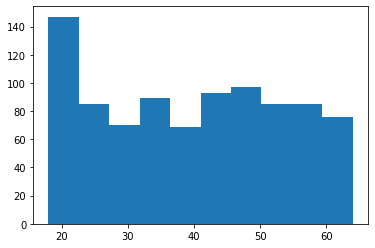

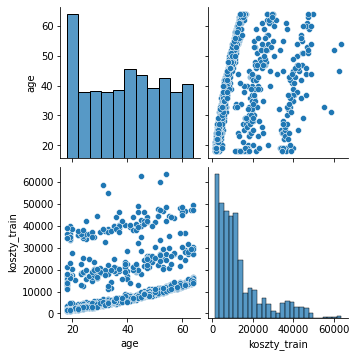

In [5]:
plt.hist(ubez_train["age"])
display(ubez_train["age"].describe())

df = pd.DataFrame(data={
    'age': ubez_train.loc[:, ('age')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### isMale - czy osoba jest mężczyzną
- Zwraca true jeśli osoba jest mężczyzną, a false jeśli kobietą.
- W zbiorze treningowym 454 mężczyzn i 442 kobiety.

In [6]:
ubez_train["isMale"].describe()

count    896.000000
mean       0.493304
std        0.500234
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: isMale, dtype: float64

### bmi 
- BMI czyli współczynnik powstały przez podzielenie masy ciała podanej w kilogramach przez kwadrat wysokości podanej w metrach.
- Przyjmuje się, że wyższe wartość BMI wiążą się ze zwiększonym ryzykiem dla zdrowia i życia.
- Średnia jest w przybliżeniu równa medianie (30.68 ~= 30.23, std = 6.17), można więc przyjąć, że wykres jest symetryczny.
- Zakres danych: 15.96-53.13

count    896.000000
mean      30.688069
std        6.176795
min       15.960000
25%       26.272500
50%       30.230000
75%       34.777500
max       53.130000
Name: bmi, dtype: float64

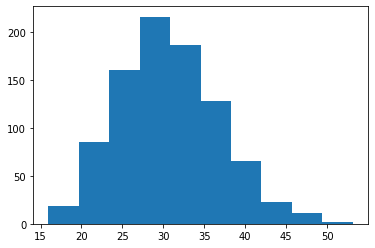

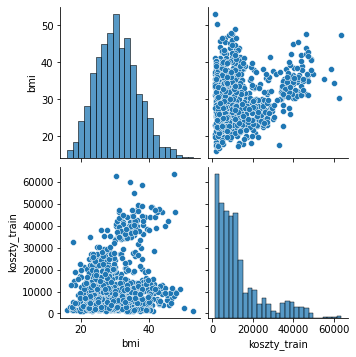

In [7]:
plt.hist(ubez_train["bmi"])
display(ubez_train["bmi"].describe())

df = pd.DataFrame(data={
    'bmi': ubez_train.loc[:, ('bmi')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### children - liczba dzieci
- Średnia jest większa niż mediana co oznacza, że wykres jest prawoskośny.
- Liczba dzieci przyjmuje wartości od 0 do 5.

count    896.000000
mean       1.093750
std        1.202476
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: children, dtype: float64

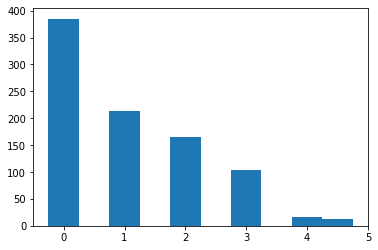

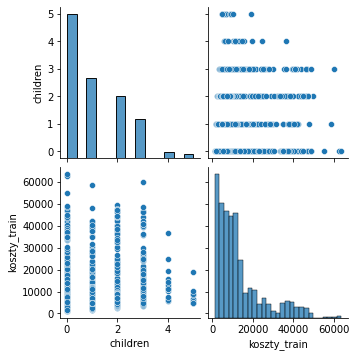

In [8]:
plt.hist(ubez_train["children"], align = "left" )
display(ubez_train["children"].describe())

df = pd.DataFrame(data={
    'children': ubez_train.loc[:, ('children')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### smoker - czy osoba jest paląca 
- Spośród 896 osób ze zbioru treningowego 717 jest paląca, a 179 nie.

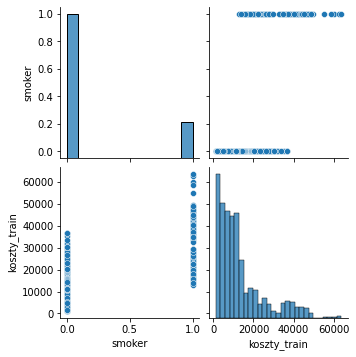

,smoker,koszty_train
smoker,1.000000,0.768143
koszty_train,0.768143,1.000000


In [9]:
ubez_train["smoker"].describe()

df = pd.DataFrame(data={
    'smoker': ubez_train.loc[:, ('smoker')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()
df.corr()

### isWest - czy osoba mieszka na zachodzie Stanów Zjedoczonych
- Spośród 896 osób ze zbioru treningowego 450 żyje na zachodzie kraju, a 436 na wschodzie.

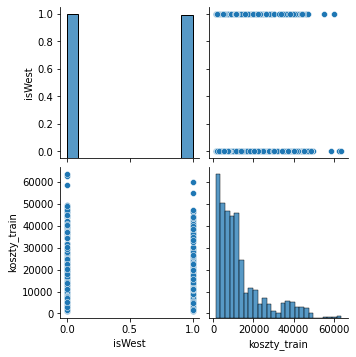

,isWest,koszty_train
isWest,1.000000,-0.098012
koszty_train,-0.098012,1.000000


In [10]:
ubez_train["isWest"].describe()

df = pd.DataFrame(data={
    'isWest': ubez_train.loc[:, ('isWest')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()
df.corr()

### isNorth - czy osoba mieszka na północy Stanów Zjednoczonych
- Spośród 896 osób ze zbioru treningowego 473 żyje na północy kraju, a 423 na południu.


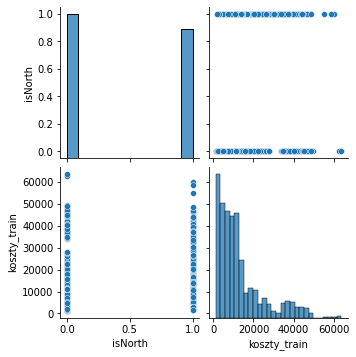

,isNorth,koszty_train
isNorth,1.000000,-0.015585
koszty_train,-0.015585,1.000000


In [11]:
ubez_train["isNorth"].describe()

df = pd.DataFrame(data={
    'isNorth': ubez_train.loc[:, ('isNorth')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()
df.corr()

## Relacja w zbiorze danych
### Relacje między zmiennymi
- Korelacje między zmiennymi w zasadzie nie występują.
- Najwyższy współczynnik korelacji mają cechy bmi oraz isNorth (-0.237).
- Taki wynik wydaje się być zrozumiały z racji, że przedstawione cechy opisuję nie zależne od siebie dane. 

### Relacje z wielkością estymowaną
- Największą korelacją z kolumną *charges* charakteryzuje się cecha *smoker* (0.768). Wydaje, się to być dość zrozumiałą zależnością, jako że od dawna wiadomym jest, że palenie papierosów powoduje wiele bardzo poważnych chorób. Z tego względu ubezpieczyciel byłby, narażony na znacznie większe koszty opieki medycznej takiego pacjenta.
- Nieznacza korelacja występuje również dla wieku ubezpieczanego, a więc dla kolumny *age* (0.29). Jest to również dość zrozumiałe, jako że starsi ludzi są narażeni na większą ilość chorób i z reguły mają one cięższy przebieg.
- Dość dziwna wydaje się tak mała wartość współczynnika korelacji pomiędzi liczbą dzieci (*children*) oraz wielkością składki ubezpieczeniowej. Wydawałoby się, iż wielkość mówiąca o liczbie osób podlegających ubezpieczeniu powinna mieć znacznie większy wpływ na jego cenę.

,age,bmi,children,smoker,isMale,isNorth,isWest,charges
age,1.000000,0.118271,0.061732,-0.050488,-0.016912,0.035379,0.004147,0.290174
bmi,0.118271,1.000000,0.020976,-0.031631,0.020418,-0.237132,-0.138863,0.177120
children,0.061732,0.020976,1.000000,0.014444,0.008475,-0.017963,0.041210,0.089397
smoker,-0.050488,-0.031631,0.014444,1.000000,0.070899,-0.008418,-0.084302,0.768143
isMale,-0.016912,0.020418,0.008475,0.070899,1.000000,0.001487,-0.031313,0.050838
isNorth,0.035379,-0.237132,-0.017963,-0.008418,0.001487,1.000000,0.024343,-0.015585
isWest,0.004147,-0.138863,0.041210,-0.084302,-0.031313,0.024343,1.000000,-0.098012
charges,0.290174,0.177120,0.089397,0.768143,0.050838,-0.015585,-0.098012,1.000000


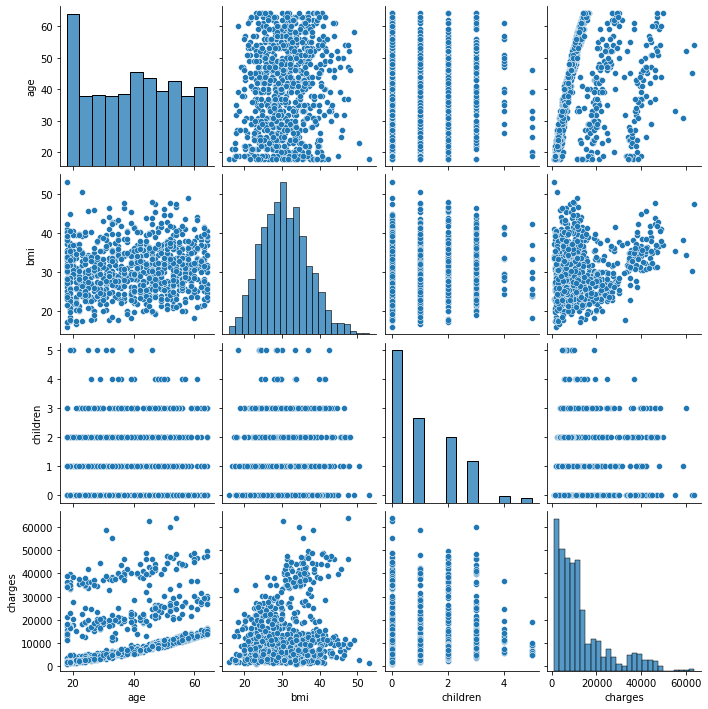

In [12]:
ubez_analysis = ubez_train.copy()
ubez_analysis.loc[:,'charges'] = koszty_train

display(ubez_analysis.corr())
sns.pairplot(ubez_analysis[["age","bmi","children","charges"]]);

## Opracowanie własnych cech

### bmi_abs
Wzrost BMI niekoniecznie jest czymś niegatywny. U każdego człowieka może zachodzić zarówno niedowaga jak i nadwaga.  
Z tego powodu powstała zmienna **bmi_abs**, która jest wyznaczona w następujący sposób:
- jeśli **bmi** należy do przedziału <19;24> wtedy **bmi_abs** ma wartość ***0***
- jeśli **bmi** jest mniejsze od 19 wtedy **bmi_abs** jest równe wartości bezwzględnej z różnicy oryginalnej wartości bmi oraz 19 (`abs( 19 - bmi )`)
- jeśli **bmi** jest większe od 24 wtedy **bmi_abs** jest równe różnicy oryginalnej wartości bmi oraz 24 (`bmi - 24`)

Przedział wykorzystany do wyznaczenia wartości nowej zmiennej nie jest przypadtkowy, jest to przedział wartośći współczynnika BMI uważanych za optymalne.

In [13]:
ubez_train.loc[:, ('bmi_abs')] = ubez_train.loc[:, ('bmi')].apply(lambda x: x-24 if x>24 else abs(19-x) if x<19 else 0)
ubez_test.loc[:, ('bmi_abs')] = ubez_test.loc[:, ('bmi')].apply(lambda x: x-24 if x>24 else abs(19-x) if x<19 else 0)

c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


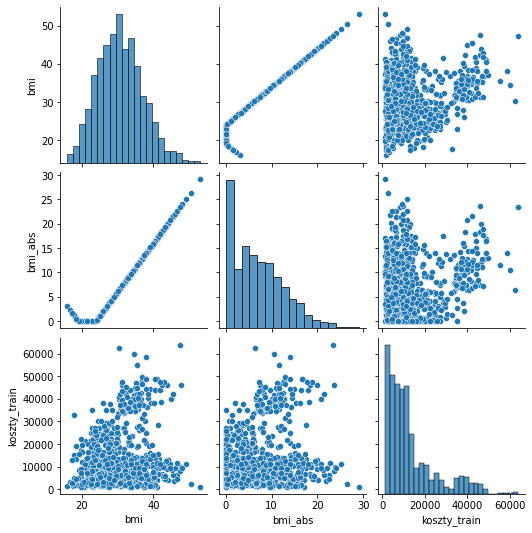

In [14]:
df = pd.DataFrame(data={
    'bmi': ubez_train.loc[:, ('bmi')],
    'bmi_abs': ubez_train.loc[:, ('bmi_abs')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### body_fatigue
Jak wiadomo, zła dieta i związana z nią waga z wiekiem osoby powoduje szybsze niszczenie organizmu. Z tego powodu postwała zmienna **body_fatigue**. Zmienna ta została obliczona po wymnożeniu wieku przez współczynnik BMI (`body_fatigue = age * bmi`)

In [15]:
ubez_train.loc[:, ('body_fatigue')] = ubez_train.loc[:, ('age')] * ubez_train.loc[:, ('bmi')]
ubez_test.loc[:, ('body_fatigue')] = ubez_test.loc[:, ('age')] * ubez_test.loc[:, ('bmi')]

c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


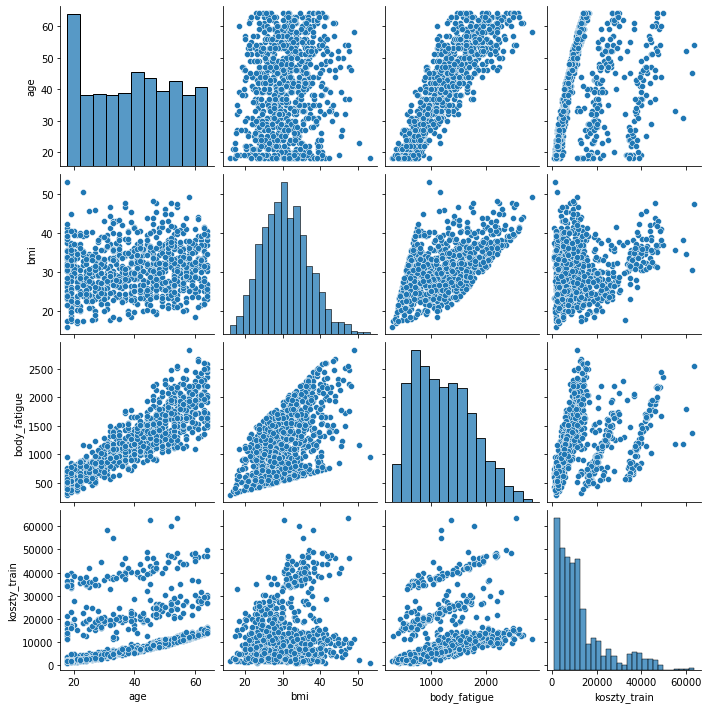

In [16]:
df = pd.DataFrame(data={
    'age': ubez_train.loc[:, ('age')],
    'bmi': ubez_train.loc[:, ('bmi')],
    'body_fatigue': ubez_train.loc[:, ('body_fatigue')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

### smoker_bmi
Nadwagę potęguje palenie papierowsów  
Z tego powodu postwała zmienna `smoker_bmi` = `bmi` * `smoker`

In [17]:
ubez_train.loc[:, ('smoker_bmi')] = ubez_train.loc[:, ('age')] * (1+ubez_train.loc[:, ('smoker')])
ubez_test.loc[:, ('smoker_bmi')] = ubez_test.loc[:, ('age')] * (1+ubez_test.loc[:, ('smoker')])

c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


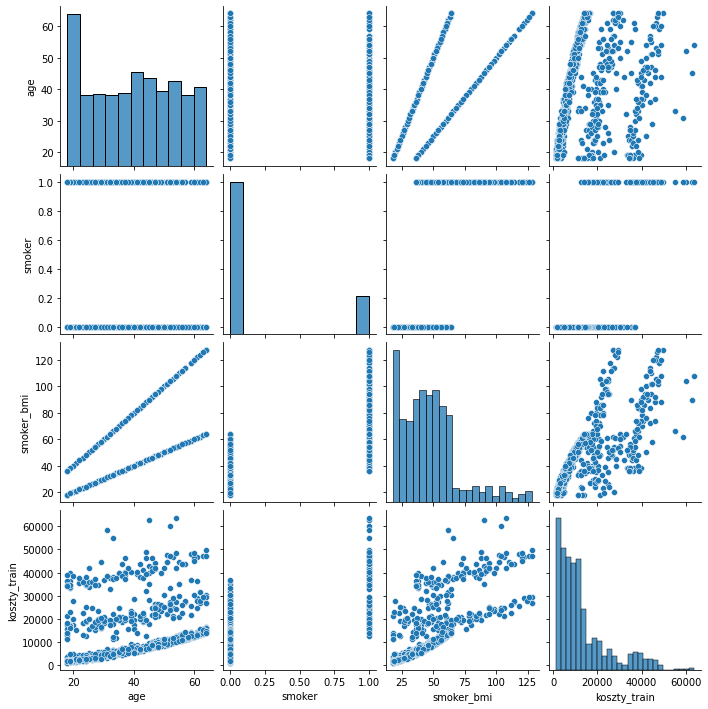

In [18]:
df = pd.DataFrame(data={
    'age': ubez_train.loc[:, ('age')],
    'smoker': ubez_train.loc[:, ('smoker')],
    'smoker_bmi': ubez_train.loc[:, ('smoker_bmi')],
    'koszty_train': koszty_train
})

# wyświetlenie dwuwymiarowej zależności między zmiennymi
sns.pairplot(df, kind="scatter")
plt.show()

## Wyznaczenie najbardziej znaczących cech 4 metodami

In [19]:
feature_num = 4

### 1. Forward stepwise

In [20]:
import sys

In [21]:
def regresion(X, y):
    pinw = np.linalg.pinv(X)
    return np.dot(pinw, y)

In [22]:
possible_features = ubez_train.columns
chosen_features = list()

for _ in range(feature_num):
    best_feature_rss = sys.maxsize
    best_feature_index = 0
    
    for idx, future in enumerate(possible_features):
        test_features = chosen_features.copy()
        test_features.append(future)
        
        w = regresion(ubez_train[test_features],koszty_train)
        y_pred = np.dot(ubez_test[test_features],w)
        error = koszty_test - y_pred
        rss = np.dot(error, error.T)
        
        if rss < best_feature_rss:
            best_feature_rss = rss
            best_feature_index = idx
        
    best_feature = possible_features[best_feature_index]
    chosen_features.append(best_feature)
    possible_features = np.delete(possible_features,best_feature_index)
    
    display(f"Chosen: {best_feature}, RSS: {rss}")
    
display(f"Final features: {chosen_features}")

final_features_forward_stepwise = chosen_features
final_w_forward_stepwise = regresion(ubez_train[chosen_features], koszty_train)

'Chosen: smoker_bmi, RSS: 31519287611.41449'

'Chosen: smoker, RSS: 27175590690.190674'

'Chosen: body_fatigue, RSS: 15453338469.507336'

'Chosen: age, RSS: 15394165207.04061'

"Final features: ['smoker_bmi', 'smoker', 'body_fatigue', 'age']"

### 2. Backward stepwise

In [23]:
remaining_features = ubez_train.columns

for _ in range(remaining_features.shape[0] - 4):
    wrost_feature_rss = 0
    wrost_feature_index = 0;
    
    for idx, future in enumerate(remaining_features):
        test_features = remaining_features.copy()
        test_features = np.delete(test_features,idx)
        
        w = regresion(ubez_train[test_features],koszty_train)
        y_pred = np.dot(ubez_test[test_features],w)
        error = koszty_test - y_pred
        rss = np.dot(error, error.T)
        
        if rss >= wrost_feature_rss:
            wrost_feature_rss = rss
            wrost_feature_index = idx
    
    display(f"Deleated {remaining_features[wrost_feature_index]} RSS: {wrost_feature_rss}")
    remaining_features = np.delete(remaining_features, wrost_feature_index)
    
display(f"Final features: {remaining_features}")

final_features_backward_stepwise = remaining_features
final_w_backward_stepwise = regresion(ubez_train[remaining_features], koszty_train)

'Deleated smoker RSS: 19139510106.848885'

'Deleated smoker_bmi RSS: 61636798346.71347'

'Deleated isMale RSS: 61927801731.5834'

'Deleated bmi_abs RSS: 62002151152.396095'

'Deleated body_fatigue RSS: 62492718557.73861'

'Deleated age RSS: 67553459716.46642'

"Final features: Index(['bmi', 'children', 'isNorth', 'isWest'], dtype='object')"

### 3. Lasso

In [24]:
def coordinate_descent_l1_penalty(X, y, w, lambda_ = 0.01, num_iters=100):
    m,n = X.shape
    
    # wykonujemy określoną ilość iteracji
    for _ in range(num_iters): 
        # obliczamy dla każdej kolumny odzielnie
        for j in range(n):
            # wyciany interesującą nas kolumnę
            X_j = X[:,j].reshape(-1,1)
            # wyznaczamy wartość estymowaną dla wcześniejszych współczyników
            y_pred = np.dot(X, w)
            # wyznaczamy rho
            rho = np.dot(X_j.T, (y - y_pred  + w[j]*X_j))
                
            # wykorzystujemy pewien threshold,
            # służy on abyśmy sprytnie omineli niewygodny dla nas punkt 0 gdzie nie ma pochodnej
            if rho < - lambda_:
                w[j] = rho + lambda_
            elif rho >  lambda_:
                w[j] = rho - lambda_
            else: 
                w[j] = 0
            
    return w.flatten()

'Końcowe lambda: 41943.04'

'Współczyniki:'

array([     0.        ,      0.        ,      0.        , 199549.45513141,
            0.        ,      0.        ,      0.        ,  34771.75107837,
        44431.14732238, 228895.82570284])

"Final features: Index(['smoker', 'bmi_abs', 'body_fatigue', 'smoker_bmi'], dtype='object')"

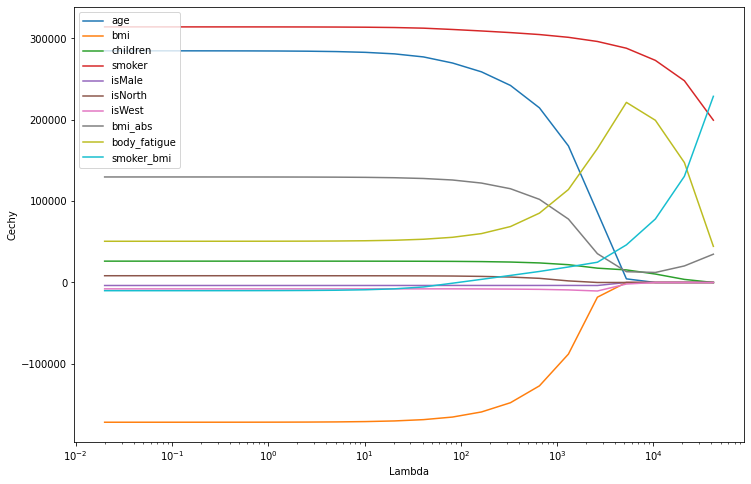

In [25]:
features_lasso = ubez_train.columns
# tworzym X oraz y
# przekształcam do numpy array, ponieważ dla typu DataFrame liczyło bardzo długo każdą z iteracji
X = ubez_train.to_numpy()
y = koszty_train.to_numpy().reshape(-1,1)

# normalizacja X
X = X / (np.linalg.norm(X,axis = 0))

lambda_list = list()
w_list = list()

# dodajemy licznik, który jest odpowiedzialny za zwiększanie kary
lambda_counter = 1
while True:
    # w każdej iteracji kara jest coraz większa
    lambda_ = 0.01*2**lambda_counter
    
    # wyznaczamy współczynniki
    w = np.zeros((features_lasso.shape[0],1))
    w = coordinate_descent_l1_penalty(X, y, w, lambda_ = lambda_, num_iters=100)
    
    lambda_list.append(lambda_)
    w_list.append(w)
    
    # jeśli zostało mniej niż 'feature_num' nieujemnych współczyników, przerwamy pętlę
    if w.nonzero()[0].shape[0] <= feature_num:
        break

    lambda_counter = lambda_counter + 1

# wykreślenie wykresu
plt.figure(figsize = (12,8))

lambda_array = np.array(lambda_list)
w_matrix = np.array(w_list)

for i in range(features_lasso.shape[0]):
    plt.plot(lambda_array, w_matrix[:,i], label = features_lasso[i])

plt.xlabel('Lambda')
plt.ylabel('Cechy')
plt.xscale('log')
plt.legend()

# drukowanie końcowe
final_features_lasso = features_lasso[w.nonzero()[0]]
final_w_lasso = regresion(ubez_train[final_features_lasso], koszty_train)

display(f"Końcowe lambda: {lambda_}")
display("Współczyniki:", w)
display(f"Final features: {final_features_lasso}")

### 4. Elastic-net

In [26]:
from sklearn.linear_model import ElasticNet 

'Końcowe lambda: 81.92'

'Współczyniki:'

array([ 0.        ,  0.        ,  0.        ,  5.62585661,  0.        ,
       -0.        , -0.        ,  0.02462694,  0.18716455,  2.06810499])

"Final features: Index(['smoker', 'bmi_abs', 'body_fatigue', 'smoker_bmi'], dtype='object')"

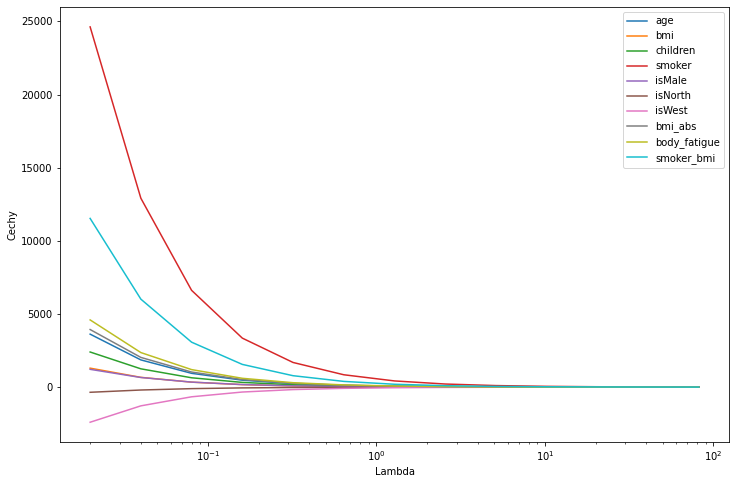

In [27]:
features = ubez_train.columns
# tworzym X oraz y
# przekształcam do numpy array, ponieważ dla typu DataFrame liczyło bardzo długo każdą z iteracji
X = ubez_train.to_numpy()
y = koszty_train.to_numpy().reshape(-1,1)

# normalizacja X
X = X / (np.linalg.norm(X,axis = 0))

lambda_list = list()
w_list = list()

# dodajemy licznik, który jest odpowiedzialny za zwiększanie kary
lambda_counter = 1
while True:
    # w każdej iteracji kara jest coraz większa
    lambda_ = 0.01*2**lambda_counter
    
    e_net = ElasticNet(alpha = lambda_) 
    e_net.fit(X, y)
    
    w = e_net.coef_

    lambda_list.append(lambda_)
    w_list.append(w)
    
    # jeśli zostało mniej niż 'feature_num' nieujemnych współczyników, przerwamy pętlę
    if w.nonzero()[0].shape[0] <= feature_num:
        break

    lambda_counter = lambda_counter + 1

# wykreślenie wykresu
plt.figure(figsize = (12,8))

lambda_array = np.array(lambda_list)
w_matrix = np.array(w_list)

for i in range(features.shape[0]):
    plt.plot(lambda_array, w_matrix[:,i], label = features[i])

plt.xlabel('Lambda')
plt.ylabel('Cechy')
plt.xscale('log')
plt.legend()

# drukowanie końcowe
final_features_elastic_net = features[w.nonzero()[0]]
final_w_elastic_net = regresion(ubez_train[final_features_elastic_net], koszty_train)

display(f"Końcowe lambda: {lambda_}")
display("Współczyniki:", w)
display(f"Final features: {final_features_elastic_net}")

## Określenie najlepszego zestawu cech

In [28]:
def get_rss(X, y, w):
    # Wylicz przewidywaną wartość
    y_pred = np.dot(X, w)
    # Policz błąd
    error = y_pred - y
    # Podnieś błędy do kwadratu i zsumuj je
    return np.dot(error,error.T)    

Forward stepwise: Train SSE= 3.5051E+10 , Test SSE= 1.5288E+10
Features:  ['smoker_bmi', 'smoker', 'body_fatigue', 'age'] 

Backward stepwise: Train SSE= 1.1973E+11 , Test SSE= 6.7553E+10
Features:  Index(['bmi', 'children', 'isNorth', 'isWest'], dtype='object') 

Lasso: Train SSE= 3.5144E+10 , Test SSE= 1.5394E+10
Features:  Index(['smoker', 'bmi_abs', 'body_fatigue', 'smoker_bmi'], dtype='object') 

Elastic-net: Train SSE= 3.5144E+10 , Test SSE= 1.5394E+10
Features:  Index(['smoker', 'bmi_abs', 'body_fatigue', 'smoker_bmi'], dtype='object') 



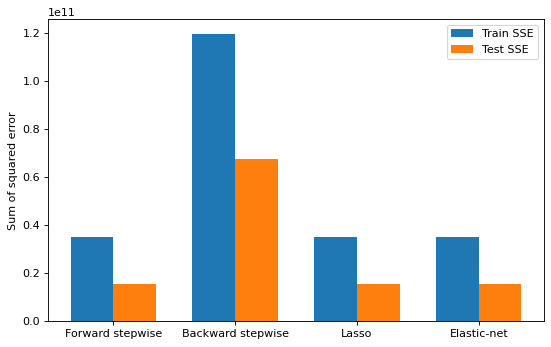

In [34]:
data_list = [
    {
        "comment": "Forward stepwise",
        "features": final_features_forward_stepwise,
        "w": final_w_forward_stepwise
    },
    {
        "comment": "Backward stepwise",
        "features": final_features_backward_stepwise,
        "w": final_w_backward_stepwise
    },
    {
        "comment": "Lasso",
        "features": final_features_lasso,
        "w": final_w_lasso
    },
    {
        "comment": "Elastic-net",
        "features": final_features_elastic_net,
        "w": final_w_elastic_net
    }
] 

labels = list()
train_sse = list()
test_sse = list()

for data in data_list:
    _tr_sse = get_rss(ubez_train[data['features']], koszty_train, data['w'])
    _te_sse = get_rss(ubez_test[data['features']], koszty_test, data['w'])
    print(f"{data['comment']}: Train SSE= {_tr_sse:.4E} , Test SSE= {_te_sse:.4E}\nFeatures: ", data['features'], '\n')
    
    labels.append(data['comment'])
    train_sse.append(_tr_sse)
    test_sse.append(_te_sse)

    
# rysowanie wykresu    
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5), dpi= 80)
rects1 = ax.bar(x - width/2, train_sse, width, label='Train SSE')
rects2 = ax.bar(x + width/2, test_sse, width, label='Test SSE')

ax.set_ylabel('Sum of squared error')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


Jak widać na powyższym wykresie spośród 4 wykorzystanych metod doboru cech tylko jedna dała odstające wyniki - **Backward stepwise**. Metoda ta dała kilkukrotnie gorsze wyniki patrząc zarówno na błąd uczenia jak i błąd testowy. 

Metoda **Lasso** jak i **ElasticNet** wyznaczyła identyczny zestaw cech - *smoker*, *bmi_abs*, *body_fatigue*, *smoker_bmi* - oraz uzyskała takie same wartości błędów dla zbioru treningowego jak i testowego. Metody różnią się tym, że metoda **ElasticNet** posiada dodatkwy współczniki kary, który ogranicza wariancję modelu. Dobierane cech, w modelu regresji, cechowały się na tyle małą wariancją, że obydwie metody wybrały te same cechy.

## Przygotowanie modelu
W związku z bardzo zbliżonymi wartościami błędów dla 2 zestawów cech przygotowując nasz model wykorzystamy obydwa zestawy cech:
- *smoker_bmi*, *smoker*, *body_fatigue*, *age* - **Forward stepwise**
- *smoker*, *bmi_abs*, *body_fatigue*, *smoker_bmi* - **Lasso** / **ElasticNet**
W celu uzyskania lepszych rezultatów, modelu wykorzystamy SVM oraz regresję grzbietową:

In [62]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

### Zestaw cech wyznaczony przez metode *Forward stepwise*
*smoker_bmi*, *smoker*, *body_fatigue*, *age*

In [58]:
fwd_best_models = []

#### Wyznaczenie najlepszego modelu regresji SVM

In [59]:
model = svm.LinearSVR()
parameters = {'C': [0.25, 0.5, 1.0, 2.0, 4.0, 10.0, 20.0, 30.0, 40.0, 50.0, 75.0, 100.0]}

clf = GridSearchCV(model, parameters)
clf.fit(ubez_train[final_features_forward_stepwise], koszty_train)

c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge,

c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge,

GridSearchCV(estimator=LinearSVR(),
             param_grid={'C': [0.25, 0.5, 1.0, 2.0, 4.0, 10.0, 20.0, 30.0, 40.0,
                               50.0, 75.0, 100.0]})

In [60]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017194,0.001912,0.002197,0.000398,0.25,{'C': 0.25},0.466653,0.605375,0.466214,0.520183,0.507975,0.513280,0.050885,6
1,0.019747,0.001934,0.001596,0.000489,0.5,{'C': 0.5},0.527677,0.658265,0.503858,0.562760,0.549783,0.560469,0.052846,5
2,0.019320,0.001160,0.002197,0.000405,1,{'C': 1.0},0.543215,0.712958,0.531119,0.574885,0.582008,0.588837,0.064900,4
3,0.020245,0.001075,0.001798,0.000400,2,{'C': 2.0},0.567124,0.662307,0.591317,0.570298,0.615264,0.601262,0.035059,3
4,0.023740,0.000924,0.001596,0.000488,4,{'C': 4.0},0.578805,0.677430,0.630059,0.546567,0.609640,0.608500,0.044576,2
5,0.023736,0.001466,0.001797,0.000400,10,{'C': 10.0},0.165526,0.704923,0.560078,-0.346465,0.377183,0.292249,0.366949,9
6,0.023535,0.001855,0.001998,0.000635,20,{'C': 20.0},0.081199,0.609292,0.643150,0.419540,0.476505,0.445937,0.200121,8
7,0.026329,0.002936,0.001593,0.000489,30,{'C': 30.0},0.519776,0.701996,0.650537,0.616913,0.648871,0.627619,0.060421,1
8,0.026938,0.003033,0.001985,0.000014,40,{'C': 40.0},-8.310251,0.697359,0.500720,0.472586,0.498710,-1.228175,3.541956,11
9,0.027722,0.002987,0.001995,0.000002,50,{'C': 50.0},0.428308,-1.869942,0.546679,0.539981,0.240149,-0.022965,0.930118,10


In [61]:
print(clf.best_estimator_, clf.best_params_)
fwd_best_models.append({
    "name": "SVM",
    "model": clf.best_estimator_,
    "test_error": mean_squared_error(koszty_test, clf.best_estimator_.predict(ubez_test[final_features_forward_stepwise]))
})

LinearSVR(C=30.0) {'C': 30.0}


*Najlepszy model SVM wyznaczono dla `C = 30`*

#### Wyznaczenie najlepszego modelu dla regresji Ridge

In [64]:
model = Ridge()
parameters = {
    'alpha': [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192, 16.384]
}

clf = GridSearchCV(model, parameters)
clf.fit(ubez_train[final_features_forward_stepwise], koszty_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.002, 0.004, 0.008, 0.016, 0.032,
                                   0.064, 0.128, 0.256, 0.512, 1.024, 2.048,
                                   4.096, 8.192, 16.384]})

In [65]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005585,0.005698,0.002397,0.000796,0.001,{'alpha': 0.001},0.720899,0.671194,0.738882,0.694660,0.711754,0.707478,0.023089,11
1,0.003595,0.001618,0.001793,0.000752,0.002,{'alpha': 0.002},0.720894,0.671204,0.738882,0.694658,0.711753,0.707478,0.023085,10
2,0.002589,0.000795,0.001201,0.000401,0.004,{'alpha': 0.004},0.720885,0.671224,0.738882,0.694655,0.711752,0.707479,0.023078,9
3,0.002593,0.000798,0.001596,0.000489,0.008,{'alpha': 0.008},0.720866,0.671264,0.738881,0.694649,0.711748,0.707482,0.023064,8
4,0.002593,0.000489,0.001197,0.000399,0.016,{'alpha': 0.016},0.720827,0.671344,0.738881,0.694636,0.711742,0.707486,0.023035,7
5,0.002596,0.000796,0.002191,0.000980,0.032,{'alpha': 0.032},0.720751,0.671504,0.738879,0.694611,0.711728,0.707495,0.022978,6
6,0.002195,0.000400,0.001595,0.000488,0.064,{'alpha': 0.064},0.720598,0.671821,0.738874,0.694560,0.711701,0.707511,0.022865,5
7,0.002393,0.000789,0.001602,0.000482,0.128,{'alpha': 0.128},0.720291,0.672447,0.738863,0.694458,0.711645,0.707541,0.022642,4
8,0.002000,0.000009,0.001586,0.000481,0.256,{'alpha': 0.256},0.719678,0.673662,0.738830,0.694249,0.711528,0.707590,0.022211,3
9,0.002209,0.000403,0.001384,0.000483,0.512,{'alpha': 0.512},0.718452,0.675958,0.738727,0.693819,0.711273,0.707646,0.021407,1


In [73]:
print(clf.best_estimator_, clf.best_params_)
fwd_best_models.append({
    "name": "Ridge",
    "model": clf.best_estimator_,
    "test_error": mean_squared_error(koszty_test, clf.best_estimator_.predict(ubez_test[final_features_forward_stepwise]))
})

Ridge(alpha=0.512) {'alpha': 0.512}


*Najlepszy model Ridge regression wyznaczono dla `alpha = 0.512`*

#### Określenie, najlepszego modelu

In [94]:
fwd_best = None
for _model in fwd_best_models:
    if not fwd_best or fwd_best['test_error'] > _model['test_error']:
        fwd_best = _model
        
print(f"Najlepszy model dla zestawu cech wyznaczonych metodą forward stepwise to {fwd_best['name']}, \na błąd dla danych testowych wynosi {fwd_best['test_error']:0.4E}")

Najlepszy model dla zestawu cech wyznaczonych metodą forward stepwise to Ridge, 
a błąd dla danych testowych wynosi 3.4584E+07


### Zestaw cech wyznaczony przez metody *Lasso* / *ElasticNet*
*smoker*, *bmi_abs*, *body_fatigue*, *smoker_bmi*

In [79]:
lasso_best_models = []

#### Wyznaczenie najlepszego modelu regresji SVM

In [80]:
model = svm.LinearSVR()
parameters = {'C': [0.25, 0.5, 1.0, 2.0, 4.0, 10.0, 20.0, 30.0, 40.0, 50.0, 75.0, 100.0]}

clf = GridSearchCV(model, parameters)
clf.fit(ubez_train[final_features_lasso], koszty_train)

c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge,

c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\users\filip choromański\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge,

GridSearchCV(estimator=LinearSVR(),
             param_grid={'C': [0.25, 0.5, 1.0, 2.0, 4.0, 10.0, 20.0, 30.0, 40.0,
                               50.0, 75.0, 100.0]})

In [81]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017369,0.001624,0.001979,0.001083,0.25,{'C': 0.25},0.405498,0.564732,0.325600,0.389878,0.429892,0.423120,0.078773,5
1,0.018355,0.000801,0.001992,0.000007,0.5,{'C': 0.5},0.453592,0.577046,0.372737,0.455436,0.471876,0.466137,0.065314,3
2,0.021944,0.002668,0.001793,0.000401,1,{'C': 1.0},0.443437,0.599335,0.382942,0.418289,0.532377,0.475276,0.079294,2
3,0.021340,0.001489,0.001792,0.000414,2,{'C': 2.0},0.347017,0.552200,0.450291,0.457197,0.407058,0.442752,0.067355,4
4,0.024738,0.002126,0.001591,0.000476,4,{'C': 4.0},0.376458,0.649185,0.548498,0.586630,0.277170,0.487588,0.138750,1
5,0.025332,0.002419,0.002189,0.000393,10,{'C': 10.0},-0.086304,-0.034390,0.318497,-0.643983,-0.036131,-0.096462,0.309698,12
6,0.023350,0.000802,0.001588,0.000484,20,{'C': 20.0},0.530545,0.295989,0.620018,0.604783,-0.766516,0.256964,0.524722,7
7,0.025932,0.001389,0.001799,0.000410,30,{'C': 30.0},0.560142,-0.074238,0.325040,-0.428836,0.606494,0.197720,0.395270,9
8,0.024135,0.002043,0.001997,0.000005,40,{'C': 40.0},0.590954,-0.655352,0.650731,-0.117068,0.558998,0.205653,0.513202,8
9,0.024734,0.001917,0.001790,0.000403,50,{'C': 50.0},0.478384,-1.339211,0.634013,0.028304,0.443728,0.049043,0.722493,10


In [82]:
print(clf.best_estimator_, clf.best_params_)
lasso_best_models.append({
    "name": "SVM",
    "model": clf.best_estimator_,
    "test_error": mean_squared_error(koszty_test, clf.best_estimator_.predict(ubez_test[final_features_lasso]))
})

LinearSVR(C=4.0) {'C': 4.0}


*Najlepszy model SVM wyznaczono dla `C = 4`*

#### Wyznaczenie najlepszego modelu dla regresji Ridge

In [83]:
model = Ridge()
parameters = {
    'alpha': [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192, 16.384]
}

clf = GridSearchCV(model, parameters)
clf.fit(ubez_train[final_features_lasso], koszty_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.002, 0.004, 0.008, 0.016, 0.032,
                                   0.064, 0.128, 0.256, 0.512, 1.024, 2.048,
                                   4.096, 8.192, 16.384]})

In [84]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002592,7.979892e-04,0.001591,0.000488,0.001,{'alpha': 0.001},0.717073,0.675987,0.741837,0.695604,0.712358,0.708572,0.022014,11
1,0.002202,3.941005e-04,0.001797,0.000391,0.002,{'alpha': 0.002},0.717070,0.675994,0.741837,0.695603,0.712357,0.708572,0.022012,10
2,0.003189,7.349927e-04,0.002194,0.000399,0.004,{'alpha': 0.004},0.717063,0.676010,0.741837,0.695601,0.712355,0.708573,0.022007,9
3,0.003187,4.016104e-04,0.001605,0.000487,0.008,{'alpha': 0.008},0.717050,0.676040,0.741837,0.695598,0.712350,0.708575,0.021997,8
4,0.002786,3.954747e-04,0.001801,0.000403,0.016,{'alpha': 0.016},0.717024,0.676102,0.741836,0.695592,0.712341,0.708579,0.021977,7
5,0.002394,4.905699e-04,0.001795,0.000399,0.032,{'alpha': 0.032},0.716972,0.676225,0.741835,0.695580,0.712323,0.708587,0.021937,6
6,0.001796,3.973400e-04,0.001594,0.000489,0.064,{'alpha': 0.064},0.716867,0.676468,0.741832,0.695556,0.712285,0.708602,0.021858,5
7,0.002197,3.948162e-04,0.001793,0.000404,0.128,{'alpha': 0.128},0.716658,0.676949,0.741824,0.695507,0.712210,0.708630,0.021702,4
8,0.002192,4.030843e-04,0.001195,0.000409,0.256,{'alpha': 0.256},0.716238,0.677887,0.741802,0.695405,0.712057,0.708678,0.021401,3
9,0.001799,4.011673e-04,0.001592,0.000490,0.512,{'alpha': 0.512},0.715395,0.679667,0.741733,0.695191,0.711739,0.708745,0.020836,2


In [89]:
print(clf.best_estimator_, clf.best_params_)
lasso_best_models.append({
    "name": "Ridge",
    "model": clf.best_estimator_,
    "test_error": mean_squared_error(koszty_test, clf.best_estimator_.predict(ubez_test[final_features_lasso]))
})

Ridge(alpha=1.024) {'alpha': 1.024}


*Najlepszy model Ridge regression wyznaczono dla `alpha = 1.024`*

#### Określenie, najlepszego modelu

In [96]:
lasso_best = None
for _model in lasso_best_models:
    if not lasso_best or lasso_best['test_error'] > _model['test_error']:
        lasso_best = _model
        
print(f"Najlepszy model dla zestawu cech wyznaczonych metodą forward stepwise to {lasso_best['name']}, \na błąd dla danych testowych wynosi {lasso_best['test_error']:0.4E}")

Najlepszy model dla zestawu cech wyznaczonych metodą forward stepwise to Ridge, 
a błąd dla danych testowych wynosi 3.4240E+07


### Wybór modelu - podsumowanie
Z powyższych eksperymentów wynika, że lepsze wyniki dla obu zestawów cech osiągamy dla regresji Ridge.

## Czy udało nam się osiągnąć początkowe założenia? 
W ostatniej części projektu sprawdzimy czy udało nam się osiągnąć [założenia opisane na początku pracy](#Cel-badań).

In [116]:
fwd_part_errors = (fwd_best['model'].predict(ubez_test[final_features_forward_stepwise]) - koszty_test)
lasso_part_errors = (lasso_best['model'].predict(ubez_test[final_features_lasso]) - koszty_test)

fwd_mape = np.sum(fwd_part_errors / koszty_test * 100) / len(koszty_test)
lasso_mape = np.sum(lasso_part_errors / koszty_test * 100) / len(koszty_test)

fwd_goal_percentage = sum(fwd_part_errors / koszty_test < 0.05) / len(koszty_test)
lasso_goal_percentage = sum(lasso_part_errors / koszty_test < 0.05) / len(koszty_test)

In [127]:
plots_data = {
    'labels': [f"{fwd_best['model']}\ncechy z Forward stepwise", 
               f"{lasso_best['model']}\ncechy z Lasso/ElasticNet"],
    'mape': [fwd_mape, lasso_mape],
    'sse': [fwd_best['test_error'], lasso_best['test_error']],
    'ape_below_5': [fwd_goal_percentage, lasso_goal_percentage]
}

### Błędy testowe

Text(0.5, 1.0, 'Sumaryczny błąd kwadratowy')

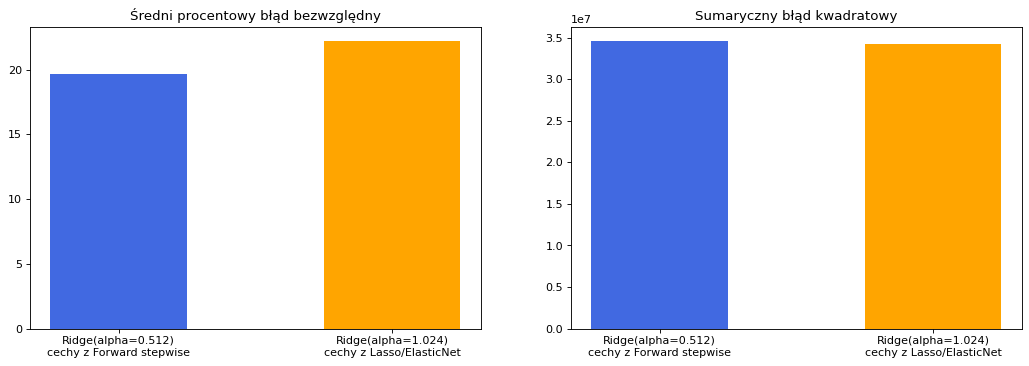

In [141]:
# rysowanie wykresu    
x = np.arange(len(plots_data['labels']))  # the label locations
width = 0.35  # the width of the bars

plt.figure(figsize=(16,5), dpi= 80)
plt.subplot(121)
plt.bar(x, plots_data['mape'], 0.5, color=['royalblue', 'orange'])
plt.xticks(x, plots_data['labels'])
plt.title("Średni procentowy błąd bezwzględny")

plt.subplot(122)
plt.bar(x, plots_data['sse'], 0.5, color=['royalblue', 'orange'])
plt.xticks(x, plots_data['labels'])
plt.title("Sumaryczny błąd kwadratowy")

Błędy dla obu modeli są podobne. 
- Błąd MAPE jest mniejszy dla modelu wykorzystującego cechy wyznaczone przy pomocy metody forward stepwise (19.65). 
- Błąd SSE jest niemalże taki sam - różni się zaledwie o jeden procent na korzyść modelu wykorzystujacego cechy wyznaczone metodą Lasso.

Text(0.5, 1.0, 'Procent przypadków testowych dla których bezwzględny błąd procentowy jest mniejszy niż 5%')

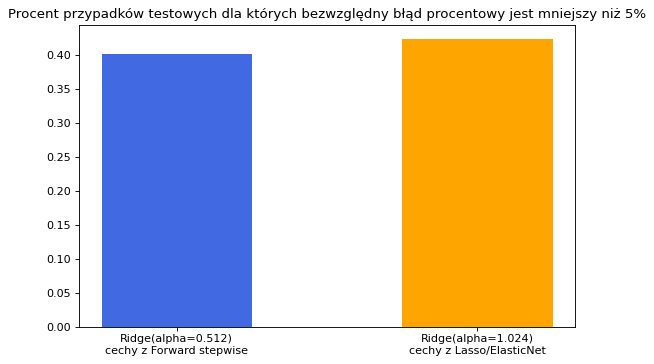

In [138]:
plt.figure(figsize=(8,5), dpi= 80)
plt.bar(x, plots_data['ape_below_5'], 0.5, color=['royalblue', 'orange'])
plt.xticks(x, plots_data['labels'])
plt.title("Procent przypadków testowych dla których bezwzględny błąd procentowy jest mniejszy niż 5%")

Jak widać na powyższym wykresie, żaden z modeli nie był w stanie osiągnąc wyników jakie założyliśmy na początku. Do spełnienia założeń zabrakło bardzo dużo, gdyż tylko nieco ponad 40% przypadków testowych osiągneło błąd na poziomie mniejszym niż 5%

In [135]:
plots_data['sse'][0] / plots_data['sse'][1]

1.0100581816084804